# This is a work-in-progress notebook

We wish to know this:

1. How well does the model identify the correct number of senses for the target word?
2. **How well does the model identify the correct senses for the target word?**
3. **How well does the model assign the right words to a given sense of the target word?**
4. How well does the model assign the senses to the time intervals for the target word?

The script will evaluate **Q2** and **Q3**. Q4 will follow.

### Filenames of different model outputs must be different

In [137]:
# Basic variables and imports:

import codecs, csv, os, time, re, io
from os import listdir
from os.path import isfile, join
from  more_itertools import unique_everseen

# directories

dir_in = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "src", "dynamic-senses","greek_input","all_results"))
dir_out = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_output"))
dir_expert = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_input"))
#dir_expert = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_input","new_texts"))

dir_parameter = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "src", "dynamic-senses","greek_input","all_parameters"))

# change parameter file and senses etc here

s_senses = io.open(dir_expert+"/senses_69419.txt","r")  # expert senses annotation
k_senses = io.open(dir_in+"/output_mus_K5_100it.dat","r") # model output
parameter_file = io.open(dir_parameter+"/params_v1.txt","r")

bugfix = 0

target_id = os.path.basename(s_senses.name)
target_id = target_id.replace("senses_","")
target_id = target_id.replace(".txt","")
print("Target ID:",target_id)

param_name = os.path.basename(parameter_file.name)
param_name = param_name.replace("params","")

print(s_senses)
print(k_senses)
print(param_name)
print(dir_out+"/"+target_id+param_name)


results_file = io.open(dir_out+"/"+target_id+param_name,"w")

# DEBUG:
#s_senses = io.open(dir_in+"/senses_69419_debug.txt","r")
#k_senses = io.open(dir_in+"/mus_debug.dat","r")
# k0 = mus4
# k1 = mus3
# k2 = mus2
# k3 = mus1
# k4 = nothing



file_senses = s_senses.readlines()[1:]
output_senses = k_senses.read()

i = 0
for line in parameter_file.readlines():
    i+=1
    if i == 4:
        line = line.split("\t")
        window_size = int(line[1])
        print("Window size:",window_size,type(window_size))
        
    if i == 13:
        line = line.split("\t")
        iterations = int(line[1])
        print("Iterations:",iterations,type(iterations))
        
    if i == 14:
        line = line.split("\t")
        start_time = int(line[1])
        print("Start time:",start_time,type(start_time))
        
    if i == 15:
        line = line.split("\t")
        end_time = int(line[1])
        print("End time:",end_time,type(end_time))
    
    if i == 16:
        line = line.split("\t")
        time_interval = int(line[1])
        print("Time interval:",time_interval,type(time_interval))

results_file.write("Target ID %s Window size %s Start time %s End time %s Time Interval %s Iterations %s\n" % (target_id,window_size,start_time,end_time,time_interval,iterations))

Target ID: 69419
<_io.TextIOWrapper name='/Users/hengchen/git/seed-semantic-change/evaluation/evaluation_input/senses_69419.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/Users/hengchen/git/seed-semantic-change/src/dynamic-senses/greek_input/all_results/output_mus_K5_100it.dat' mode='r' encoding='UTF-8'>
_v1.txt
/Users/hengchen/git/seed-semantic-change/evaluation/evaluation_output/69419_v1.txt
Window size: 5 <class 'int'>
Iterations: 100 <class 'int'>
Start time: -430 <class 'int'>
End time: 359 <class 'int'>
Time interval: 100 <class 'int'>


92

In [138]:
# Defining time periods from the output file

total_years = end_time-start_time
perioddd = 0
temp_start_time = start_time

for year in range(temp_start_time,end_time):
    if temp_start_time + time_interval < end_time:
        perioddd +=1
        print(perioddd)
        temp_start_time += time_interval

number_of_slices = perioddd + bugfix # cfr above

slice_duration = time_interval # read from the parameter file
print(slice_duration)

print(start_time,end_time)

slice_years = dict()

for period in range(0,number_of_slices):
    slice_years[period] = list()
    
    if period == number_of_slices-1:
        for i in range(latest_i,end_time):
            slice_years[period].append(i)  
    
    if period != number_of_slices-1:
        for i in range(start_time,end_time):
        
            if i > int(period*slice_duration) + start_time:
                if i < int((period+1)*slice_duration) + start_time:
                    slice_years[period].append(i)
                    latest_i = i
#print(slice_years)

1
2
3
4
5
6
7
100
-430 359


## TODO

- ~~create the notebook~~
- ~~organise the notebook~~
- ~~write "general idea" pseudocode for the evaluation~~
- ~~get input files~~
- ~~figure out data structures to store the variables~~
- ~~write actual code~~

## Q2: How well does the model identify the correct senses for the target word?

### Pseudocode 

In [139]:
# For each target word, we have a list of senses  s (given by the expert)
# For each target word, we have a list of senses k (given by the model)
# This Q consists in matching s and k, and doing so in a confident way --> confidence score

for each k:
    for each s:
        create conf(k,s)

# What is conf(k,s)?
        conf(k,s) = (p1*match(w1,s)+p2*match(w1,s)+px(wx,s))/10 WHERE
    
            px = probability of word wx 
                
                and
            
            match(wx,s) =   1/number_of_senses_assigned_to_wx if s_is_one_of_them 
            
                    or 
                            0 if w_is_not_associated_to_s
                
# Once we have gone through all s for one k, we have to choose the best k for s. How? (TBD, cfr Valerio and Barbara)

# Once all ks have been assigned to all ss (or NA), we can calculate a general confidence score for the model.
# One easy way to do that: 

conf_score_model = number_of_non_NA/k

SyntaxError: invalid syntax (<ipython-input-139-82fa54601c9a>, line 5)

### Real code

Steps:

- extract all senses from the file
- use those senses as keys for a dictionary, `dict_of_words`
- fill the dictionary: for each key, we store a list of words pertaining to that sense
- transform the lists as sets so as to remove duplicates within the same sense
- create a dictionary with a word as a key and its weight as a value, depending on how many senses it appears
- parse the model output and get the probability weights for each word
- do not take into account the first line
- take care of empty lines

Todo:




In [140]:
expert_senses = list() # list where we store all sense ids provided by expert
#sense_for_period_counter = 0




for line in file_senses: 
    cells = line.split("\t")
    sense = cells[11] # The sense ID is after the 10th tab
    if sense != 'w':
        
        
        if int(cells[12]) == 1:   ## we only take the senses annotated because of collocates and nothing else
            #print(int(s[12]))
            expert_senses.append(sense)
              
        else:
            expert_senses.append("NA") # if the reason for finding the sense is not "collocates" (1), the sense NA is created

    else:
         expert_senses.append("NA")

#print(len(expert_senses),expert_senses,len(set(expert_senses)))


expert_senses_set = list(set(expert_senses)) # we only keep the unique senses
expert_senses = list(unique_everseen(expert_senses))
print("SET",expert_senses_set)
print("ITERTOOLS",expert_senses)

number_of_s = len(expert_senses)  # we create a variable that stores the number of unique senses
print("Number of senses:",number_of_s,expert_senses)

# This dictionary has a sense as a key, and a list of words as a value. 
dict_of_words = dict()
# This list stores all words
list_of_all_words = list()
# This dictionary stores all words as keys and their weight as value
word_weight = dict()
# This dictionary stores the number of times a sense appears in a slice
sense_date_amount = dict()

# This list stores words in w and not collocates senses
list_of_NA_words = list()

dummy_counter = 0


sentences_smaller_than_window_size = 0

for i in range(0,number_of_s): # for each sense, we create a dictionary entry which has a list as value
#for i in range(2,3):
    dict_of_words[expert_senses[i]] = list()
    print(expert_senses[i])

    for line in file_senses: # we go back in the file
        cells = line.split("\t") # splitting on tabs
        if int(cells[12]) == 1:  # senses inferred from collocates
            if cells[11] == expert_senses[i]:      # we store all words for one sense 
                
        
                sentence_of_ids = cells[8] # 8 is for IDs, 9 is for words
                list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
        
        
                index_of_target = list_of_ids.index(target_id) # getting the location of the target word in the collocates
                list_of_ids_window = list()
                for n in range(index_of_target-window_size,index_of_target+window_size+1): # for every word in the window_size range
                    try:   # if there's a word it's taken into account

                        list_of_ids_window.append(list_of_ids[n])
                
                    except IndexError: # if there isn't, too bad
                        sentences_smaller_than_window_size += 1

                for word_id in list_of_ids_window:
                    if int(cells[12]) == 1:
                        
                        
                        if cells[11] == expert_senses[i]:  

                            dict_of_words[expert_senses[i]].append(word_id)                    
                            
                    
                    
                    list_of_all_words.append(word_id) # we store all words, we'll iterate over that for scores
            
            
            # if the sense is "w", the collocates are put in the "NA words"
            
            if cells[11] == "w":
                #print("W")
                sentence_of_ids = cells[8] # 8 is for IDs, 9 is for words
                list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
                index_of_target = list_of_ids.index(target_id) # getting the location of the target word in the collocates
                list_of_ids_window = list()
                for n in range(index_of_target-window_size,index_of_target+window_size+1): # for every word in the window_size range
                    try:   # if there's a word it's taken into account

                        list_of_NA_words.append(list_of_ids[n])
                        list_of_all_words.append(list_of_ids[n])
                    except IndexError:
                        dummy_counter +=1
                    
        else:  # words that are in "non collocates senses"
            #print("NON COLOC")
            sentence_of_ids = cells[8] # 8 is for IDs, 9 is for words
            #print(sentence_of_ids)
            list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
            index_of_target = list_of_ids.index(target_id) # getting the location of the target word in the collocates
            #print(index_of_target)
            list_of_ids_window = list()
            #print(index_of_target-window_size,index_of_target+window_size+1)
            for n in range(index_of_target-window_size,index_of_target+window_size+1): # for every word in the window_size range
                try:   # if there's a word it's taken into account
                    #print(list_of_ids_window)
                    #print(list_of_ids[n])
                    list_of_NA_words.append(list_of_ids[n])
                    list_of_all_words.append(list_of_ids[n])
                except IndexError:
                        dummy_counter +=1
            #print(list_of_NA_words)
            
            
    # Here, we remove duplicates
    #dict_of_words[expert_senses[i]].append("79223") #testing
    
    dict_of_words[expert_senses[i]] = list(set(dict_of_words[expert_senses[i]]))
    
    
      
    print("i",i,"sense",expert_senses[i],"number of words",len(dict_of_words[expert_senses[i]]))
    print("words",set(dict_of_words[expert_senses[i]]))
    print("\n\n")

# NOW THAT WE HAVE A LIST OF NA WORDS 
# We can pyt that in the dict_of_words[expert_sense] dictionary
#print("NA words",list_of_NA_words)
list_of_NA_words = list(set(list_of_NA_words))
dict_of_words["NA"] = list_of_NA_words

print("sentences smaller than window size",window_size,":",sentences_smaller_than_window_size)
#print("dummy",dummy_counter)
print("number of NA words:",len(list_of_NA_words))
print("same?",len(dict_of_words["NA"]))

results_file.write("Expert senses %s Total %s \n" %(expert_senses,len(expert_senses)))

SET ['NA', 'mus-2', 'mus-1', 'mus-4']
ITERTOOLS ['mus-1', 'NA', 'mus-4', 'mus-2']
Number of senses: 4 ['mus-1', 'NA', 'mus-4', 'mus-2']
mus-1
i 0 sense mus-1 number of words 549
words {'42827', '51815', '49331', '23690', '1564', '7529', '70105', '17962', '64586', '85672', '3289', 'nlsj69856', '56406', '42842', '45671', '67104', '27764', '66173', '28036', '18706', '21431', '57262', '26447', '114731', '105344', 'nlsj98815', '91800', '83783', '7779', '41633', '71308', 'nlsj52509', '83251', '41705', '116244', '58478', '3327', '103957', '26114', '103871', 'nlsj96033', '63814', '45917', '15893', '35710', '47917', '50679', '39195', '65983', '69036', '3398', '85306', '83434', '38966', '34366', '69252', '4927', '36790', '116470', '109403', '112720', '20728', 'nlsj801', '4493', '6449', '76530', '82954', 'nlsj40053', '71118', '3241', '106502', '59005', '70708', '51727', '19268', '49589', 'nlsj60710', '31964', '116058', '68174', '65089', '26048', '76157', '74126', '18334', '21830', '115845', '9525

57

In [141]:
sense_date_amount = dict() # dict where we have the number of senses for [sense,period]

# this dictionary is now initialised with 0 for each CORRECT sense,period pair we have
for sense in expert_senses:
    for period in slice_years.keys():
        sense_date_amount[sense,period] = 0
        
print(sense_date_amount,"\n")        

counter = 0

for line in file_senses: 
    #print(len(file_senses))
    cells = line.split("\t")
    sense = cells[11] # The sense ID is after the 10th tab
    if sense != 'w':
        #print(sense)
        
        
        if int(cells[12]) == 1:   ## we only take the senses annotated because of collocates and nothing else
            #print(int(s[12]))
            #expert_senses.append(sense)
            
            for period in slice_years.keys():
                if int(cells[0]) in slice_years[period]:
                    #sense_for_period_counter += 1
                    sense_date_amount[sense,period] += 1
                    counter += 1
                    
print(sense_date_amount)
print(counter)

{('mus-1', 0): 0, ('mus-1', 1): 0, ('mus-1', 2): 0, ('mus-1', 3): 0, ('mus-1', 4): 0, ('mus-1', 5): 0, ('mus-1', 6): 0, ('NA', 0): 0, ('NA', 1): 0, ('NA', 2): 0, ('NA', 3): 0, ('NA', 4): 0, ('NA', 5): 0, ('NA', 6): 0, ('mus-4', 0): 0, ('mus-4', 1): 0, ('mus-4', 2): 0, ('mus-4', 3): 0, ('mus-4', 4): 0, ('mus-4', 5): 0, ('mus-4', 6): 0, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 0, ('mus-2', 6): 0} 

{('mus-1', 0): 7, ('mus-1', 1): 3, ('mus-1', 2): 1, ('mus-1', 3): 3, ('mus-1', 4): 7, ('mus-1', 5): 24, ('mus-1', 6): 48, ('NA', 0): 0, ('NA', 1): 0, ('NA', 2): 0, ('NA', 3): 0, ('NA', 4): 0, ('NA', 5): 0, ('NA', 6): 0, ('mus-4', 0): 21, ('mus-4', 1): 1, ('mus-4', 2): 0, ('mus-4', 3): 1, ('mus-4', 4): 0, ('mus-4', 5): 1, ('mus-4', 6): 9, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 0, ('mus-2', 6): 22}
148


In [142]:
# For every word in the list of words that we have
# we count the number of senses it appears in
# we use that number to divide its importance: 1 sense = 1 importance; 2 senses = 0.5 importance
# this can be finetuned

print(expert_senses)
#print("list_of_NA_words",list_of_NA_words,"\n\n")
#print("list of mus 1 words",dict_of_words['mus-1'])

# This dictionary stores words in w and not collocates senses
word_weight_NA = dict()

for word in list_of_all_words:
#word = "113560"
    x = 0  # number of times word appears in different senses excluding NAs
    z = 0 # number of times word appears in different senses including NAs
#print(word)
    for i in range(0,number_of_s):
        if word in dict_of_words[expert_senses[i]]:
            #if word == "105344":
            #    print("YO")
                
            if expert_senses[i] != "NA":
                x += 1 
                #print("froot the loop")
                

    if x != 0:
        word_weight[word] = float(1/x)
        #print(word,"this is a x!=0",x,"this is its weight",float(1/x))
        
        if word in list_of_NA_words:
            z = x + 1
            #print(z)
            #print(word,"this is a z",z,"this is its weight",float(1/z))
            
            word_weight_NA[word] = float(1/z)
            
    else:  # if word doesn't exist in non-NA senses
        word_weight_NA[word] = 1/1
        word_weight[word] = 0  # with this we prevent the case that a word that is ONLY in NA has no weight 
  
        
    #else: 
    #    word_weight_NA[word] = word_weight[word]
        
#print(word_weight_NA)    
#print(word,word_weight[word])

#print(word_weight_NA["53826"])

#for key in word_weight_NA.keys():
#    print(key,word_weight_NA[key])
for word in list_of_all_words:
    try: 
        print(word,word_weight[word])
    except KeyError:
        print(word,"isnt in non-NA senses")
    try:
        print(word,word_weight_NA[word])
    except KeyError:
        print(word,"isnt in NA sense")

['mus-1', 'NA', 'mus-4', 'mus-2']
36165 1.0
36165 isnt in NA sense
18334 1.0
18334 isnt in NA sense
34855 1.0
34855 isnt in NA sense
41633 1.0
41633 isnt in NA sense
71314 1.0
71314 isnt in NA sense
69419 0.3333333333333333
69419 0.25
15380 1.0
15380 isnt in NA sense
42890 1.0
42890 isnt in NA sense
110302 1.0
110302 isnt in NA sense
104311 1.0
104311 isnt in NA sense
16400 1.0
16400 isnt in NA sense
50093 1.0
50093 isnt in NA sense
47665 1.0
47665 isnt in NA sense
63143 1.0
63143 isnt in NA sense
45996 0.3333333333333333
45996 0.25
113560 0.5
113560 isnt in NA sense
69419 0.3333333333333333
69419 0.25
62204 1.0
62204 0.5
22739 1.0
22739 isnt in NA sense
57262 0.5
57262 isnt in NA sense
29828 1.0
29828 isnt in NA sense
23468 1.0
23468 isnt in NA sense
110598 1.0
110598 isnt in NA sense
75263 1.0
75263 isnt in NA sense
69419 0.3333333333333333
69419 0.25
19641 1.0
19641 0.5
nlsj78558 1.0
nlsj78558 isnt in NA sense
80761 1.0
80761 0.5
95258 1.0
95258 isnt in NA sense
26447 1.0
26447 0.5


69419 0.3333333333333333
69419 0.25
69419 0.3333333333333333
69419 0.25
22882 1.0
22882 isnt in NA sense
62204 1.0
62204 0.5
83718 1.0
83718 isnt in NA sense
21431 1.0
21431 isnt in NA sense
69419 0.3333333333333333
69419 0.25
98712 0
98712 1.0
48549 0
48549 1.0
35581 0
35581 1.0
46195 1.0
46195 0.5
35642 0
35642 1.0
69419 0.3333333333333333
69419 0.25
98712 0
98712 1.0
48549 0
48549 1.0
35581 0
35581 1.0
116058 1.0
116058 isnt in NA sense
75306 1.0
75306 isnt in NA sense
46195 1.0
46195 0.5
111895 1.0
111895 isnt in NA sense
103942 1.0
103942 isnt in NA sense
69419 0.3333333333333333
69419 0.25
3398 1.0
3398 0.5
112943 1.0
112943 isnt in NA sense
83253 1.0
83253 isnt in NA sense
22100 1.0
22100 0.5
74735 0.5
74735 isnt in NA sense
69419 0.3333333333333333
69419 0.25
82954 1.0
82954 isnt in NA sense
93388 0.3333333333333333
93388 isnt in NA sense
46646 1.0
46646 isnt in NA sense
nlsj52509 1.0
nlsj52509 isnt in NA sense
nlsj98815 1.0
nlsj98815 isnt in NA sense
70768 0.5
70768 isnt in NA

109729 isnt in NA sense
51785 1.0
51785 isnt in NA sense
13985 1.0
13985 isnt in NA sense
113560 0.5
113560 isnt in NA sense
101851 1.0
101851 isnt in NA sense
26039 1.0
26039 isnt in NA sense
69419 0.3333333333333333
69419 0.25
20836 1.0
20836 isnt in NA sense
55391 1.0
55391 isnt in NA sense
39180 1.0
39180 isnt in NA sense
101851 1.0
101851 isnt in NA sense
45996 0.3333333333333333
45996 0.25
39180 1.0
39180 isnt in NA sense
97605 1.0
97605 isnt in NA sense
621 1.0
621 isnt in NA sense
69419 0.3333333333333333
69419 0.25
20836 1.0
20836 isnt in NA sense
101851 1.0
101851 isnt in NA sense
45996 0.3333333333333333
45996 0.25
58142 1.0
58142 isnt in NA sense
22660 1.0
22660 isnt in NA sense
53015 1.0
53015 isnt in NA sense
6339 1.0
6339 isnt in NA sense
29883 0.5
29883 isnt in NA sense
69419 0.3333333333333333
69419 0.25
4493 0.5
4493 isnt in NA sense
101851 1.0
101851 isnt in NA sense
51369 1.0
51369 isnt in NA sense
85099 1.0
85099 isnt in NA sense
85306 0.5
85306 isnt in NA sense
39

69419 0.3333333333333333
69419 0.25
nlsj3887 1.0
nlsj3887 isnt in NA sense
45996 0.3333333333333333
45996 0.25
65552 0.3333333333333333
65552 0.25
75652 1.0
75652 isnt in NA sense
214 1.0
214 isnt in NA sense
60317 1.0
60317 isnt in NA sense
nlsj7772 1.0
nlsj7772 isnt in NA sense
113881 1.0
113881 isnt in NA sense
nlsj70384 1.0
nlsj70384 isnt in NA sense
101982 1.0
101982 isnt in NA sense
69419 0.3333333333333333
69419 0.25
nlsj86871 1.0
nlsj86871 isnt in NA sense
60317 1.0
60317 isnt in NA sense
nlsj7772 1.0
nlsj7772 isnt in NA sense
69419 0.3333333333333333
69419 0.25
41918 0
41918 1.0
113163 0
113163 1.0
69419 0.3333333333333333
69419 0.25
41918 0
41918 1.0
113163 0
113163 1.0
65934 1.0
65934 isnt in NA sense
51737 1.0
51737 isnt in NA sense
32263 1.0
32263 isnt in NA sense
58262 1.0
58262 isnt in NA sense
101982 1.0
101982 isnt in NA sense
69419 0.3333333333333333
69419 0.25
47745 1.0
47745 isnt in NA sense
113881 1.0
113881 isnt in NA sense
60317 1.0
60317 isnt in NA sense
102474 

#### parsing output.dat
- split on "===============  per time  ===============" and keep first part
- transform that into a list, then
- get lines that start with "p(w|s)"
- count those, k = that number
- split the line on ":", keep the second part
- split the rest on ";", it's [ID] = prob_from_this_ID

In [143]:
lines_output = output_senses.split("===============  per time  ===============")[0].split("\n")

number_of_the_k = 0

k_words_with_prob = dict()

for line in lines_output:
    if line[:6] == "p(w|s)":
        line = line.split(":")[1]
        line = line.split(";")
        #print(number_of_the_k,line)
        dico_word_prob = dict()
        temp_dict = dict()
        k_words_with_prob[number_of_the_k] = list()
        
        line = line[:-1] # last item of the list is empty
        
        total_probability = 0 # to have relative probs
        print(line)
        for word_prob in line:
            print(word_prob)

        
            #word_prob = word_prob.split(",")
            #for word in word_prob:
            probability = re.findall("([\d.\w]*)",word_prob)
            if probability:
                probability = list(filter(None,probability))
                    
            total_probability += float(probability[1])
            print("word id",probability[0],"; probability",probability[1])
        
            dico_word_prob[probability[0]] = float(probability[1])
        #print(type(k_words_with_prob[number_of_the_k]))
        
        for i in dico_word_prob.keys():
            
            temp_dict[i] = float(dico_word_prob[i]/total_probability)
            k_words_with_prob[number_of_the_k] = temp_dict
            
            print(k_words_with_prob[number_of_the_k])
            
        #k_words_with_prob[number_of_the_k] = [float(dico_word_prob[i]/total_probability) for i in dico_word_prob]
        #print(k_words_with_prob[number_of_the_k])
        print(temp_dict)
        number_of_the_k += 1
        

results_file.write("Output senses %s \n\n" %(number_of_the_k))

['  28355 (0.088) ', ' 69419 (0.069) ', ' 57460 (0.056) ', ' 114587 (0.042) ', ' 42071 (0.041) ', ' 35267 (0.035) ', ' 51647 (0.035) ', ' 64448 (0.023) ', ' 45980 (0.018) ', ' 53826 (0.017) ']
  28355 (0.088) 
word id 28355 ; probability 0.088
 69419 (0.069) 
word id 69419 ; probability 0.069
 57460 (0.056) 
word id 57460 ; probability 0.056
 114587 (0.042) 
word id 114587 ; probability 0.042
 42071 (0.041) 
word id 42071 ; probability 0.041
 35267 (0.035) 
word id 35267 ; probability 0.035
 51647 (0.035) 
word id 51647 ; probability 0.035
 64448 (0.023) 
word id 64448 ; probability 0.023
 45980 (0.018) 
word id 45980 ; probability 0.018
 53826 (0.017) 
word id 53826 ; probability 0.017
{'28355': 0.2075471698113207}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849}
{'2835

18

#### k_words_with_prob
This dictionary has the sense number 'k' as keys and the a dictionary of [word] = probability as values.
Example below.

In [144]:
for word in set(list_of_all_words):
    if word == "105344":
        print("found all")
        
for word in set(list_of_NA_words):
    if word == "105344":
        print("found NA")

found all


In [145]:
#print("Probability for word ID 5390 in sense k = 4:",k_words_with_prob[4]["5390"])
print(type(k_words_with_prob[4]))

#print(k_words_with_prob[4]["15047"])

print(word_weight["105344"])
#print(word_weight_NA["105344"])


<class 'dict'>
1.0


In [146]:
for key in k_words_with_prob.keys():
    print("output sense",key)
    for i in range(0,number_of_s):
        print("\texpert sense number ", i, expert_senses[i])
        for second_key in k_words_with_prob[key].keys(): # Barbara's note: shouldn't it be k_words_with_prob[i] here?
            print("\t\tword from annotation for sense", key, ":", second_key)
            if second_key in dict_of_words[expert_senses[i]]:
                if expert_senses[i] != "NA":
                    print("\t\t\t\tnormal")
                    print("\t\t\tword ", second_key, "is in output for sense", key, "with probability:", k_words_with_prob[key][second_key], "and weight:", word_weight[second_key])

                else:
                    print("\t\t\t\tNA")
                    print("\t\t\tword ", second_key, "is in output for sense", key, "with probability:", k_words_with_prob[key][second_key], "and weight:", word_weight_NA[second_key])

                
# Here we get all the senses and for each sense we do a matching between the k words and s words and get the probability
# For some reason the first word for each sense arrives several times


output sense 0
	expert sense number  0 mus-1
		word from annotation for sense 0 : 28355
				normal
			word  28355 is in output for sense 0 with probability: 0.2075471698113207 and weight: 1.0
		word from annotation for sense 0 : 69419
				normal
			word  69419 is in output for sense 0 with probability: 0.16273584905660377 and weight: 0.3333333333333333
		word from annotation for sense 0 : 57460
		word from annotation for sense 0 : 114587
				normal
			word  114587 is in output for sense 0 with probability: 0.0990566037735849 and weight: 1.0
		word from annotation for sense 0 : 42071
		word from annotation for sense 0 : 35267
				normal
			word  35267 is in output for sense 0 with probability: 0.08254716981132075 and weight: 1.0
		word from annotation for sense 0 : 51647
				normal
			word  51647 is in output for sense 0 with probability: 0.08254716981132075 and weight: 1.0
		word from annotation for sense 0 : 64448
				normal
			word  64448 is in output for sense 0 with probability: 0.

In [147]:
## Calculating confidence score for each (words_of_k,words_of_s) pair

# conf(k,s) = (p1*match(w1,s)+p2*match(w1,s)+px(wx,s))
        # match(wx,s) =   1/number_of_senses_assigned_to_wx if s_is_one_of_them 

    
print("number of expert senses s:",number_of_s)
print("number of model output senses k:",len(k_words_with_prob.keys()))
compteur = 0

match = dict()
conf = dict()
for k in k_words_with_prob.keys():  # for each output sense, we go through...
    print("\n")
    print("Choose best match for k =",k)
    for s in range(0,number_of_s):       # each expert sense
        
        conf[k,s] = 0 
        
        #print("expert sense",s)
        for mot in k_words_with_prob[k]:      # for each word within output by the model for the output sense
            print("k,mot",k,mot)
            print("expert_senses[s]",expert_senses[s])
            
            if expert_senses[s] == "NA":
                
                if mot in dict_of_words[expert_senses[s]]:  # if that word exists in the list of expert words for that sense

                    #print("s,dict_of_words[expert_senses[s]])",dict_of_words[expert_senses[s]])
                    print("k_words_with_prob[k][mot]",k_words_with_prob[k][mot])
                    print("word_weight[mot]",word_weight_NA[mot])

                    #for word in list_of_all_words:  # this help getting a key for a dictionary later on
                     #   if mot == word:
                    match_weighted = float((k_words_with_prob[k][mot]))*word_weight_NA[mot] #this dictionary cfr comment on line 24
                            # word_weight[word] is already "1/number_of_expert_senses_assigned_to_this_word"

                    print("sense",expert_senses[s],"mot",mot,"match_weighted",match_weighted)

                            #print(k,s,conf[k,s])


                            # To fix? 
                            # The way the code works is that all matches happen number_of_s times
                            # (number_of_s = number of expert senses)
                            # easy fix is to divide the match score by number_of_s

                    conf[k,s] = conf[k,s] + match_weighted#/4

                
                
            else:    
 
                if mot in dict_of_words[expert_senses[s]]:  # if that word exists in the list of expert words for that sense

                    #print("s,dict_of_words[expert_senses[s]])",dict_of_words[expert_senses[s]])
                    print("k_words_with_prob[k][mot]",k_words_with_prob[k][mot])
                    print("word_weight[mot]",word_weight[mot])

                    #for word in list_of_all_words:  # this help getting a key for a dictionary later on
                     #   if mot == word:
                    match_weighted = float((k_words_with_prob[k][mot]))*word_weight[mot] #this dictionary cfr comment on line 24
                            # word_weight[word] is already "1/number_of_expert_senses_assigned_to_this_word"

                    print("sense",expert_senses[s],"mot",mot,"match_weighted",match_weighted)

                            #print(k,s,conf[k,s])


                            # To fix? 
                            # The way the code works is that all matches happen number_of_s times
                            # (number_of_s = number of expert senses)
                            # easy fix is to divide the match score by number_of_s

                    conf[k,s] = conf[k,s] + match_weighted#/4

                    #else: 
                        #print(word,"has no match for sense",expert_senses[s])
                        #print(word,word_weight[word],"match",k_words_with_prob[k][mot],"match weighted",match_weighted)
                    #print("test1")
                #print("test2")
                
                    #compteur += 1
                
        #if (k,s) in conf.keys():
        
            #conf[k,s] = conf[k,s] # with or without /10
            #print("k =",k,"\t s =",s,"(= expert sense",expert_senses[s],")\t conf[k,s] =",conf[k,s])
            
            #print(compteur)
            
    #print(k_words_with_prob[k])


number of expert senses s: 4
number of model output senses k: 5


Choose best match for k = 0
k,mot 0 28355
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.2075471698113207
word_weight[mot] 1.0
sense mus-1 mot 28355 match_weighted 0.2075471698113207
k,mot 0 69419
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.16273584905660377
word_weight[mot] 0.3333333333333333
sense mus-1 mot 69419 match_weighted 0.05424528301886792
k,mot 0 57460
expert_senses[s] mus-1
k,mot 0 114587
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.0990566037735849
word_weight[mot] 1.0
sense mus-1 mot 114587 match_weighted 0.0990566037735849
k,mot 0 42071
expert_senses[s] mus-1
k,mot 0 35267
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.08254716981132075
word_weight[mot] 1.0
sense mus-1 mot 35267 match_weighted 0.08254716981132075
k,mot 0 51647
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.08254716981132075
word_weight[mot] 1.0
sense mus-1 mot 51647 match_weighted 0.08254716981132075
k,mot 0 64448


In [148]:
print(conf)

k_s_match = dict()  # k_s_match[k] = s

for k in range(0,number_of_the_k):
    print("k",k)
    liste_temp = list()
    best_s_for_k = "NA"
    conf[k,best_s_for_k] = -1

    
    for s in range(0,len(expert_senses)):
        print("conf[k,s]",conf[k,s],"s",s,"best s for k",best_s_for_k)
        #print(type(conf[k,s]))
        liste_temp.append(conf[k,s])
        
        
        try:
            if conf[k,s] > conf[k,best_s_for_k]: 
                #print("NEW best_s:",s)
                best_s_for_k = s
                
        except KeyError:
            print("key error should not happen")
        
    sorted_liste_temp = sorted(liste_temp, reverse=True)
    

    
# TODO: get the NA to be correct as well
    print("k, best s:",k,best_s_for_k)
    if conf[k,best_s_for_k] > sorted_liste_temp[1] + sorted_liste_temp[2]: # if the MAX is higher than the sum of the following two
        
        if conf[k,best_s_for_k] > 1/(len(expert_senses)+1): # if the MAX is higher than the random baseline (number of sense + NA)
            k_s_match[k] = best_s_for_k
            print("MATCH: k",k,"s",best_s_for_k)
            print("\tmax:",sorted_liste_temp[0])
            print("\tmax 2 + 3:",sorted_liste_temp[1],sorted_liste_temp[2],"sum",sorted_liste_temp[1]+sorted_liste_temp[2],"\n")
            results_file.write("MATCH: k %s and s %s \n" %(k,best_s_for_k))
            
        else:
            print("NO MATCH: k",k,"the best s was",best_s_for_k,"reason: max < 1/(# of expert senses+1)")
            print("\tmax:",sorted_liste_temp[0])
            print("\tmax 2 + 3:",sorted_liste_temp[1],sorted_liste_temp[2],"sum",sorted_liste_temp[1]+sorted_liste_temp[2],"\n")
            k_s_match[k] = "NA"
    else:
        print("NO MATCH: k",k,"the best s was",best_s_for_k,"reason: max < max2+max3")
        print("\tmax 2 + 3:",sorted_liste_temp[1],sorted_liste_temp[2],"sum",sorted_liste_temp[1]+sorted_liste_temp[2],"\n")
        k_s_match[k] = "NA"
        
        #if conf[k,best_s_for_k] > 1/(len(expert_senses)+1):
         #   print("also: reason: max < 1/(# of expert senses+1)\n")

{(0, 0): 0.6014150943396226, (0, 1): 0.09492924528301885, (0, 2): 0.2830188679245283, (0, 3): 0.07547169811320753, (1, 0): 0.17260273972602735, (1, 1): 0.3246575342465753, (1, 2): 0.09863013698630134, (1, 3): 0.14520547945205475, (2, 0): 0.2647058823529411, (2, 1): 0.029411764705882353, (2, 2): 0.09558823529411764, (2, 3): 0.5490196078431372, (3, 0): 0.3773049645390071, (3, 1): 0.1127659574468085, (3, 2): 0.5304964539007093, (3, 3): 0.024113475177304965, (4, 0): 0.2932330827067669, (4, 1): 0.4144736842105264, (4, 2): 0.11278195488721807, (4, 3): 0.03383458646616541}
k 0
conf[k,s] 0.6014150943396226 s 0 best s for k NA
conf[k,s] 0.09492924528301885 s 1 best s for k 0
conf[k,s] 0.2830188679245283 s 2 best s for k 0
conf[k,s] 0.07547169811320753 s 3 best s for k 0
k, best s: 0 0
MATCH: k 0 s 0
	max: 0.6014150943396226
	max 2 + 3: 0.2830188679245283 0.09492924528301885 sum 0.3779481132075472 

k 1
conf[k,s] 0.17260273972602735 s 0 best s for k NA
conf[k,s] 0.3246575342465753 s 1 best s for

Correct pairs (Alessandro): v1

- K0 - S0 / S1
- K1 - S3 / S1
- K2 - S3
- K3 - S2
- K4 - S0 / S1

In [149]:
# For all k->s pair we have in the k_s_match dictionary, we create the inverted dictionary :
# s_k_match[s] contains all the k assigned to that s

s_k_match = dict()
print(k_s_match)
for key in k_s_match.keys():
    try: 
        s_k_match[k_s_match[key]].append(key)
        
    except KeyError:
        s_k_match[k_s_match[key]] = list()
        s_k_match[k_s_match[key]].append(key)
        
print("for each s, the k (or more) assigned to it:",s_k_match)
        
        
    

{0: 0, 1: 1, 2: 3, 3: 2, 4: 1}
for each s, the k (or more) assigned to it: {0: [0], 1: [1, 4], 3: [2], 2: [3]}


## Q3: How well does the model assign the right words to a given sense of the target word?

In [150]:
# For each k, we use the words given by the expert as unquestionable truth.
# Judging the model's assignment of words to a given sense becomes a question of precision and recall.

# precision is all correct w weighted by their respective probabilities / all w weighted by their probabilities

for each k:
    for each w:
        if w in expert_list:
            w_weight = p*1
            numerator += w_weight
        w_weight = p*1
        denominator += w_weight
    precision = numerator/denominator
    
# recall is all correct w weighted by their respective probabilities / all w assigned to the sense by the expert
for each k:
    for each w:
        if w in expert_list:
            w_weight = p*1
            numerator += w_weight
    denominator = len(expert_list)
    recall = numerator/denominator
    
# f-score can be used as well

for each k:
    f_score = 2 * precision * recall / (precision+recall)

SyntaxError: invalid syntax (<ipython-input-150-f315d04cacf9>, line 6)

## TODO : 
1. ~~create another word_weight[] only for NA~~
2. ~~in this word_weight[], a word that is in an NA (either because w or !=1) has its weight 1/senses, BUT THAT DOES NOT AFFECT THE real word_weight[]~~
3. when a k,s match is correctly NA: precision and recall cfr picture

ALSO:
1. ~~create a s_k_match dictionary that maps s with one or more k assigned by the model. This allows to calculate a new P and R~~
2. ~~s_k_match[s] = [kx, ky] (based on matches)~~
3. ~~precision and recall for each s, and averaged precisions and recalls as well~~


### This is Pr and Re for Ks -> not taken into account

In [151]:
precision_recall_k = dict()

print("\t\t\tTHIS IS P and R FOR Ks, WE LOOK AT P and R for Ss now: below\n\n\n")

for key in k_s_match.keys():
    precision_recall_k[key] = list() # this list has first the recall then the precision then the f score
    numerator_recall = 0
    denominator_precision = 0
    numerator_precision = 0
    denominator_recall = 0
   # print()



############# NEED TO ADJUST FOR PAIRS THAT ARE NAs  --> actually no


    if k_s_match[key] == "NA":
        print("K",key,"s is NA")

    else: 
    
        for word in k_words_with_prob[int(key)]: 
            w_weight_precision = k_words_with_prob[int(key)][word] * 1
            denominator_precision += float(w_weight_precision)
        
        
        
            if word in dict_of_words[expert_senses[int(k_s_match[key])]]:   
                w_weight_recall = k_words_with_prob[int(key)][word] * 1
                numerator_recall += float(w_weight_recall)

                numerator_precision += float(w_weight_precision)
    
        for mot in dict_of_words[expert_senses[int(k_s_match[key])]]:
            denominator_recall += word_weight[mot]
        

    #denominator_recall = len(dict_of_words[expert_senses[int(key[2])]])
    #numerator_recall = numerator_recall*10
     
    
        print("For pair ks",key,k_s_match[key],":")
        recall = numerator_recall*1/denominator_recall
        recall = recall*len(dict_of_words[expert_senses[k_s_match[key]]])
    
        precision_recall_k[key].append(recall)
    
        print(len(dict_of_words[expert_senses[k_s_match[key]]]))
        print("The RECALL is",numerator_recall,"/",denominator_recall,"=",recall) 
        if numerator_precision == 0:
            print("The PRECISION IS NA")
        else:
            precision = numerator_precision/denominator_precision
            print("The PRECISION is",numerator_precision,"* number of expert words in that sense/",denominator_precision,"=",precision,"\n")
            precision_recall_k[key].append(precision)
        
        if (numerator_precision/denominator_precision)+(numerator_recall/denominator_recall) != 0: 
            fscore = (2*(precision)*(recall)/((precision)+(recall)))
            print("The F-SCORE is", fscore,"\n")
            precision_recall_k[key].append(fscore)
        
        else:
            print("No F-SCORE, can't divide by 0\n\n")
        

			THIS IS P and R FOR Ks, WE LOOK AT P and R for Ss now: below



For pair ks 0 0 :
549
The RECALL is 0.7311320754716979 / 524.5 = 0.7652840980628449
The PRECISION is 0.7311320754716979 * number of expert words in that sense/ 0.9999999999999999 = 0.731132075471698 

The F-SCORE is 0.7478183687637862 

For pair ks 1 1 :
136
The RECALL is 0.4109589041095889 / 41.00000000000001 = 1.3631807550952215
The PRECISION is 0.4109589041095889 * number of expert words in that sense/ 0.9999999999999997 = 0.410958904109589 

The F-SCORE is 0.6315300673322497 

For pair ks 2 3 :
112
The RECALL is 0.5490196078431372 / 100.99999999999999 = 0.6088138225587265
The PRECISION is 0.5490196078431372 * number of expert words in that sense/ 0.9999999999999999 = 0.5490196078431373 

The F-SCORE is 0.5773727331308111 

For pair ks 3 2 :
193
The RECALL is 0.6170212765957448 / 171.5 = 0.6943737981514796
The PRECISION is 0.6170212765957448 * number of expert words in that sense/ 1.0000000000000002 = 0.6170212765957

## P and R based on S, with adapted word weight for NA

In [152]:

### note
recall_precision_s = dict()
print(s_k_match)
#print(dict_of_words)

for key in s_k_match.keys():
    recall_precision_s[key] = list() # this list has first the recall then the precision then the f score
    numerator_recall = 0
    denominator_precision = 0
    numerator_precision = 0
    denominator_recall = 0
   # print()
    print("s and k:",key,s_k_match[key])
    
    for any_k in range(0,len(s_k_match[key])):
        #print("s",key,"k",s_k_match[key],s_k_match[key][any_k])
        print("s_k_match[key][any_k]",s_k_match[key][any_k])
      
        for word in k_words_with_prob[any_k]:
              
            denominator_precision += float(k_words_with_prob[any_k][word])
                
            print(word,key)
            if word in dict_of_words[expert_senses[key]]:
                    #print("this word is in k",any_k,"and in sense",expert_senses[key],word)
              
                numerator_precision += float(k_words_with_prob[any_k][word])
                numerator_recall += float(k_words_with_prob[any_k][word])
                        
        ### SINCE WE HAVE the possibility of having two (or more) k for each s, the expert s words should be counted k times
        
        if expert_senses[key] != "NA":
            for mot in dict_of_words[expert_senses[key]]:
                denominator_recall += word_weight[mot]
                
        if expert_senses[key] == "NA":
            for mot in dict_of_words[expert_senses[key]]:
                denominator_recall += word_weight_NA[mot]
                
    #if key != "NA":
    
    
    
    recall = numerator_recall*1/denominator_recall
    recall = recall*len(dict_of_words[expert_senses[key]])
    recall_precision_s[key].append(recall)

    precision = numerator_precision/denominator_precision
    recall_precision_s[key].append(precision)
        
    fscore = (2*(precision)*(recall)/((precision)+(recall)))
    recall_precision_s[key].append(fscore)
        
   # else: # this must be changed for NAs
        #recall_precision_s[key].append(0)
    
                    
    print("num precision",numerator_precision,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("denom precision",denominator_precision,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("num recall",numerator_recall,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("denom recall",denominator_recall,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("recall:",recall)
    print("precision:",precision)
    print("fscore:",fscore)
    results_file.write("SCORES FOR PAIR S= %s <-> {K...K}= %s: P %s R %s F %s \n" %(key,s_k_match[key],precision,recall,fscore))
        
    
    print("\n")


{0: [0], 1: [1, 4], 3: [2], 2: [3]}
s and k: 0 [0]
s_k_match[key][any_k] 0
28355 0
69419 0
57460 0
114587 0
42071 0
35267 0
51647 0
64448 0
45980 0
53826 0
num precision 0.7311320754716979 for s 0 and a total of 1 k
denom precision 0.9999999999999999 for s 0 and a total of 1 k
num recall 0.7311320754716979 for s 0 and a total of 1 k
denom recall 524.5 for s 0 and a total of 1 k
recall: 0.7652840980628449
precision: 0.731132075471698
fscore: 0.7478183687637862


s and k: 1 [1, 4]
s_k_match[key][any_k] 1
28355 1
69419 1
57460 1
114587 1
42071 1
35267 1
51647 1
64448 1
45980 1
53826 1
s_k_match[key][any_k] 4
79223 1
92927 1
46574 1
67660 1
103085 1
86112 1
101982 1
75808 1
68539 1
54607 1
num precision 0.6562419229775135 for s 1 and a total of 2 k
denom precision 1.9999999999999996 for s 1 and a total of 2 k
num recall 0.6562419229775135 for s 1 and a total of 2 k
denom recall 220.8333333333334 for s 1 and a total of 2 k
recall: 0.4041459691695478
precision: 0.3281209614887568
fscore: 0.3

In [153]:
print(precision_recall_k)
total_recall = 0
total_precision = 0
total_fscore = 0
for key in precision_recall_k:
    try:
        total_recall += precision_recall_k[key][0]
    except IndexError:
        print("nothing for k",key)
    try: 
        total_precision += precision_recall_k[key][1]
    except IndexError:
        print("nothing for k",key)
        
    try: 
        total_fscore += precision_recall_k[key][2]
    except IndexError:
        print("nothing for k",key)
        
        
print("AVERAGED SCORES BASED ON Ks:")    
print("averaged recall = ",total_recall/number_of_the_k)
print("averaged precision = ",total_precision/number_of_the_k)
print("averaged fscore = ",total_fscore/number_of_the_k)
print("\n")


print(recall_precision_s)
total_recall = 0
total_precision = 0
total_fscore = 0
for key in recall_precision_s:
    try:
        total_recall += recall_precision_s[key][0]
    except IndexError:
        print("nothing for s",key)
    try: 
        total_precision += recall_precision_s[key][1]
    except IndexError:
        print("nothing for s",key)
        
    try: 
        total_fscore += recall_precision_s[key][2]
    except IndexError:
        print("nothing for s",key)
        


print("AVERAGED SCORES BASED ON Ss:")    
print("averaged recall = ",total_recall/len(expert_senses))  # or should I divide by the number of Ks?
print("averaged precision = ",total_precision/len(expert_senses))
print("averaged fscore = ",total_fscore/len(expert_senses))
results_file.write("Averaged scores: P %s R %s F %s\n\n" %(total_precision/len(expert_senses),total_recall/len(expert_senses),total_fscore/len(expert_senses)))

{0: [0.7652840980628449, 0.731132075471698, 0.7478183687637862], 1: [1.3631807550952215, 0.410958904109589, 0.6315300673322497], 2: [0.6088138225587265, 0.5490196078431373, 0.5773727331308111], 3: [0.6943737981514796, 0.6170212765957447, 0.6534162215801302], 4: [1.9204107830551986, 0.5789473684210527, 0.8896818316978888]}
AVERAGED SCORES BASED ON Ks:
averaged recall =  1.0704126513846943
averaged precision =  0.5774158464882444
averaged fscore =  0.6999638445009733


{0: [0.7652840980628449, 0.731132075471698, 0.7478183687637862], 1: [0.4041459691695478, 0.3281209614887568, 0.36218695241775517], 3: [0.22753596114328414, 0.20518867924528303, 0.2157852777039596], 2: [0.44059079157269376, 0.3915094339622642, 0.4146025830162798]}
AVERAGED SCORES BASED ON Ss:
averaged recall =  0.4593892049870927
averaged precision =  0.4139877875420005
averaged fscore =  0.43509829547544515


82

In [154]:
print(expert_senses)

['mus-1', 'NA', 'mus-4', 'mus-2']


In [119]:
#for i in expert_senses:
    #print(i,dict_of_words[i])

## Qx: Model(s) comparison against annotated subcorpus (sense importance evolution + sense emergence)

In [97]:
for key in slice_years.keys():
    print(key,slice_years[key],"\n")

0 [-429, -428, -427, -426, -425, -424, -423, -422, -421, -420, -419, -418, -417, -416, -415, -414, -413, -412, -411, -410, -409, -408, -407, -406, -405, -404, -403, -402, -401, -400, -399, -398, -397, -396, -395, -394, -393, -392, -391, -390, -389, -388, -387, -386, -385, -384, -383, -382, -381, -380, -379, -378, -377, -376, -375, -374, -373, -372, -371, -370, -369, -368, -367, -366, -365, -364, -363, -362, -361, -360, -359, -358, -357, -356, -355, -354, -353, -352, -351, -350, -349, -348, -347, -346, -345, -344, -343, -342, -341, -340, -339, -338, -337, -336, -335, -334, -333, -332, -331] 

1 [-329, -328, -327, -326, -325, -324, -323, -322, -321, -320, -319, -318, -317, -316, -315, -314, -313, -312, -311, -310, -309, -308, -307, -306, -305, -304, -303, -302, -301, -300, -299, -298, -297, -296, -295, -294, -293, -292, -291, -290, -289, -288, -287, -286, -285, -284, -283, -282, -281, -280, -279, -278, -277, -276, -275, -274, -273, -272, -271, -270, -269, -268, -267, -266, -265, -264, -2

## getting the number of hits per sense per period

sense_date_amount = dict()

for sense in sense_year.keys():
   
    print("Sense:",sense)
    counter = 0
    for i in range(0,number_of_slices):
        #print("period",i,"years for that sense in that period",sense_year[sense])
        
        
        
        #print(sense_year[sense])
        for year in sense_year[sense]:
        
            if year in slice_years[i]:
                counter += 1
                #print(sense_year[sense][i])
                
        sense_date_amount[sense,i] = counter           
    print(sense,counter)
    
print(sense_date_amount)

## getting the relative number of hits per sense per period
(for plotting)

In [98]:
total_period = dict()

sense_period_relative = dict()

for i in range(0,number_of_slices):
    for entry in expert_senses:
        
# for period i we store for each sense the number of times the sense is seen
        
        try:
            total_period[i] += sense_date_amount[entry,i]
        except KeyError:
            total_period[i] = 0
            total_period[i] += sense_date_amount[entry,i]
            
        #print(i,entry,"+",sense_date_amount[entry,i],"=",total_period[i])
        
        
print("total period",total_period)
print("sense date amount",sense_date_amount)
        
for key in sense_date_amount:
    
    # for each (sense,period) pair we divide the number by the total number of words at that period
    
    print(key,"total for this sense at this period",sense_date_amount[key],"total period",total_period[key[1]])
    
    sense_period_relative[key] = float(sense_date_amount[key]/total_period[key[1]])
    print("relative",sense_period_relative[key])
  
print(sense_period_relative)        

period_relative = dict()
temp_list = list()

for i in range(0,number_of_slices):
    temp_list = list()
    for entry in expert_senses:
        if len(temp_list) < len(expert_senses):
            temp_list.append(sense_period_relative[entry,i])
            print(entry,i,sense_period_relative[entry,i])
        
    period_relative[i] = temp_list
        
        
print(period_relative)
print(number_of_slices)

total period {0: 23, 1: 4, 2: 1, 3: 3, 4: 2, 5: 35, 6: 44}
sense date amount {('mus-1', 0): 2, ('mus-1', 1): 4, ('mus-1', 2): 1, ('mus-1', 3): 2, ('mus-1', 4): 2, ('mus-1', 5): 14, ('mus-1', 6): 14, ('NA', 0): 0, ('NA', 1): 0, ('NA', 2): 0, ('NA', 3): 0, ('NA', 4): 0, ('NA', 5): 0, ('NA', 6): 0, ('mus-4', 0): 21, ('mus-4', 1): 0, ('mus-4', 2): 0, ('mus-4', 3): 1, ('mus-4', 4): 0, ('mus-4', 5): 21, ('mus-4', 6): 8, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 0, ('mus-2', 6): 22}
('mus-1', 0) total for this sense at this period 2 total period 23
relative 0.08695652173913043
('mus-1', 1) total for this sense at this period 4 total period 4
relative 1.0
('mus-1', 2) total for this sense at this period 1 total period 1
relative 1.0
('mus-1', 3) total for this sense at this period 2 total period 3
relative 0.6666666666666666
('mus-1', 4) total for this sense at this period 2 total period 2
relative 1.0
('mus-1', 5) total for this sense a

## Plotting expert annotation

In [99]:
print(valeurs)
print(s_k_match)
print(i_colours)

{'0': [0.06797006677118084, 0.1214816905125435, 0.17669827020366105, 0.12895879539169736, 0.5048911771209171], '1': [0.07790171994077955, 0.17290706997570546, 0.27958592359688145, 0.07859446761922315, 0.39101081886741035], '2': [0.043116996463148594, 0.11447298831651283, 0.36562180932583266, 0.06528654631166778, 0.41150165958283824], '3': [0.09615350585735916, 0.0712382724299806, 0.45412589580600876, 0.12193385096189659, 0.2565484749447548], '4': [0.18943680519928655, 0.04746197723506132, 0.3559183313197357, 0.15253906981744492, 0.2546438164284715], '5': [0.2707895370827565, 0.11626292785519915, 0.3022599440527665, 0.21633130282134833, 0.09435628818792949], '6': [0.19094741083098585, 0.12263953089787188, 0.34777206706744807, 0.12509514825925955, 0.2135458429444348]}
{'NA': [0, 2, 3, 4], 2: [1]}
{('0', 0): 'b', ('0', 1): 'g', ('0', 2): 'r', ('0', 3): 'c', ('1', 0): 'b', ('1', 1): 'g', ('1', 2): 'r', ('1', 3): 'c', ('2', 0): 'b', ('2', 1): 'g', ('2', 2): 'r', ('2', 3): 'c', ('3', 0): 'b'

Period 0 [8, 0, 91, 0]
Period 1 [100, 0, 0, 0]
Period 2 [100, 0, 0, 0]
Period 3 [66, 0, 33, 0]
Period 4 [100, 0, 0, 0]
Period 5 [40, 0, 60, 0]
Period 6 [31, 0, 18, 50]


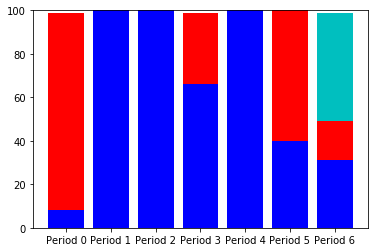

In [100]:
import numpy as np
import matplotlib.pyplot as plt

valeurs = period_relative
colours = ['b','g','r','c','m','y','k'] #to make sure colours remain the same throughout all slices
i_colours = dict()  # this dictionary stores the colour of a S

valeurs2 = dict()

for key in valeurs.keys():
    #print(key)
    key2 = "Period "+str(key)
    list_temp = list()
    for item in valeurs[key]:
        list_temp.append(int(item*100))   # let's have percentages and not .xx
    valeurs2[key2] = list_temp

    #for value in valeurs
    

for key,vals in valeurs2.items():
    print(key,vals)
    
    for i in range(0,len(vals)):        
        if i == 0:
            previous = 0
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            i_colours[key[-1:],i] = colours[i]
            
        else:         
            previous = vals[i-1] + previous
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            i_colours[key[-1:],i] = colours[i]
            
plt.xticks(range(len(valeurs2)), valeurs2.keys())

expert_image = s_senses.name.split("/")[-1]

#plt.figure(figsize=(20,10))
image = plt.gcf()
image.savefig(dir_out+"/"+expert_image+".png")
plt.show()



In [26]:
print(valeurs2.keys())

dict_keys(['Period 0', 'Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6'])


In [42]:
print(k_s_match)

for key,vals in valeurs2.items():
    print(key,vals)
    print(type(key),type(vals))
    for i in range(0,len(vals)):
        print("expert sense",i,"=",vals[i],"has the colour",colours[i])


{0: 0, 1: 2, 2: 0, 3: 0, 4: 0}
Period 0 [25, 0, 75, 0]
<class 'str'> <class 'list'>
expert sense 0 = 25 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 75 has the colour r
expert sense 3 = 0 has the colour c
Period 1 [75, 0, 25, 0]
<class 'str'> <class 'list'>
expert sense 0 = 75 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 25 has the colour r
expert sense 3 = 0 has the colour c
Period 2 [100, 0, 0, 0]
<class 'str'> <class 'list'>
expert sense 0 = 100 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 0 has the colour r
expert sense 3 = 0 has the colour c
Period 3 [75, 0, 25, 0]
<class 'str'> <class 'list'>
expert sense 0 = 75 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 25 has the colour r
expert sense 3 = 0 has the colour c
Period 4 [100, 0, 0, 0]
<class 'str'> <class 'list'>
expert sense 0 = 100 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 0 has the colour r
expert sen

liste_number_year = list() # creating a list because matplotlib wants a tuple
for key in sense_date_amount.keys():
    #print(key)
    liste_number_year.append(sense_date_amount[key])
    
tuple_number_year = tuple(liste_number_year)
#print(tuple_number_year)

period_number = dict()

for key in sense_date_amount.keys():
    compteur = 0
    if key[1] in range(0,number_of_slices):
        print(key,sense_date_amount[key[0],key[1]])
        compteur += sense_date_amount[key[0],key[1]]
        
        try :
            period_number[key[1]] += compteur
        except KeyError:
            period_number[key[1]] = 0
            period_number[key[1]] += compteur
            
        
for entry in period_number:
    print("période",entry,"number of uses",period_number[entry])


## Reading model output for plotting

lines_output_plot = output_senses.split("===============  per time  ===============")[1].split("\n")
period_relative_model = dict()


for i in range(0,len(lines_output_plot)):
    if lines_output_plot[i][0:5] == "Time=":  # if a line starts with "time" we take it into account
        for x in range(i,i+number_of_the_k+1): # for every "number of  the k" lines that follow
            #print(lines_output_plot[x])
            if lines_output_plot[x][0:5] == "Time=": # if a line starts with "time" we take the value for the slice
                period = lines_output_plot[x][5:6]
                templist = list()
                
            if lines_output_plot[x][0:5] != "Time=":  # if a line doesn't start with "time" but is considered(cf line3)
                ligne = re.split("\s{3,}",lines_output_plot[x]) # we take the first part of the line (importance of that K)
                templist.append(float(ligne[0]))
            #print(period,templist)
            
        period_relative_model[str(period)] = templist

In [30]:
print(period_relative_model)

{'0': [0.06797006677118084, 0.1214816905125435, 0.17669827020366105, 0.12895879539169736, 0.5048911771209171], '1': [0.07790171994077955, 0.17290706997570546, 0.27958592359688145, 0.07859446761922315, 0.39101081886741035], '2': [0.043116996463148594, 0.11447298831651283, 0.36562180932583266, 0.06528654631166778, 0.41150165958283824], '3': [0.09615350585735916, 0.0712382724299806, 0.45412589580600876, 0.12193385096189659, 0.2565484749447548], '4': [0.18943680519928655, 0.04746197723506132, 0.3559183313197357, 0.15253906981744492, 0.2546438164284715], '5': [0.2707895370827565, 0.11626292785519915, 0.3022599440527665, 0.21633130282134833, 0.09435628818792949], '6': [0.19094741083098585, 0.12263953089787188, 0.34777206706744807, 0.12509514825925955, 0.2135458429444348]}


## Plotting model output


Period 0 [0.06797006677118084, 0.1214816905125435, 0.17669827020366105, 0.12895879539169736, 0.5048911771209171]
<class 'str'> <class 'list'>


0 b
0 b
0 b
0 b


2 r


Period 1 [0.07790171994077955, 0.17290706997570546, 0.27958592359688145, 0.07859446761922315, 0.39101081886741035]
<class 'str'> <class 'list'>


0 b
0 b
0 b
0 b


2 r


Period 2 [0.043116996463148594, 0.11447298831651283, 0.36562180932583266, 0.06528654631166778, 0.41150165958283824]
<class 'str'> <class 'list'>


0 b
0 b
0 b
0 b


2 r


Period 3 [0.09615350585735916, 0.0712382724299806, 0.45412589580600876, 0.12193385096189659, 0.2565484749447548]
<class 'str'> <class 'list'>


0 b
0 b
0 b
0 b


2 r


Period 4 [0.18943680519928655, 0.04746197723506132, 0.3559183313197357, 0.15253906981744492, 0.2546438164284715]
<class 'str'> <class 'list'>


0 b
0 b
0 b
0 b


2 r


Period 5 [0.2707895370827565, 0.11626292785519915, 0.3022599440527665, 0.21633130282134833, 0.09435628818792949]
<class 'str'> <class 'list'>


0 b
0 b
0 b

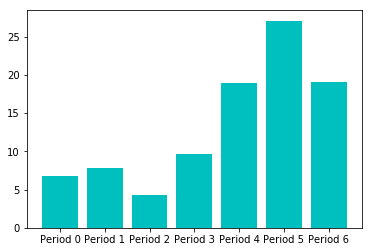

In [58]:
lines_output_plot = output_senses.split("===============  per time  ===============")[1].split("\n")
period_relative_model = dict()


for i in range(0,len(lines_output_plot)):
    if lines_output_plot[i][0:5] == "Time=":  # if a line starts with "time" we take it into account
        for x in range(i,i+number_of_the_k+1): # for every "number of  the k" lines that follow
            #print(lines_output_plot[x])
            if lines_output_plot[x][0:5] == "Time=": # if a line starts with "time" we take the value for the slice
                period = lines_output_plot[x][5:6]
                templist = list()
                
            if lines_output_plot[x][0:5] != "Time=":  # if a line doesn't start with "time" but is considered(cf line3)
                ligne = re.split("\s{3,}",lines_output_plot[x]) # we take the first part of the line (importance of that K)
                templist.append(float(ligne[0]))
            #print(period,templist)
            
        period_relative_model[str(period)] = templist

valeurs = period_relative_model
colours = ['b','g','r','c','m','y','k','w'] #to make sure colours remain the same throughout all slices


valeurs3 = dict()

for key in valeurs.keys():
    #print(key)
    key2 = "Period "+str(key)
    list_temp = list()
    for item in valeurs[key]:
        list_temp.append(item)   
    valeurs3[key2] = list_temp



for key,vals in valeurs3.items():
    print(key,vals)
    print(type(key),type(vals))
    
    for i in range(0,len(vals)):        
        if i == 0:
            previous = 0
  #          plt.bar(x=key, height=vals[i]*100,bottom=previous*100,color=colours[i])
            for y in s_k_match[i]:
                try:
                    plt.bar(x=key, height=vals[i]*100,bottom=previous*100,color=i_colours[key[-1:],s_k_match[i][y]])
                except KeyError:
                    print("")
                except IndexError:
                    print("")
            
        else:         
            previous = vals[i-1] + previous
#            plt.bar(x=key, height=vals[i]*100,bottom=previous*100,color=colours[i])
            try:
                for y in s_k_match[i]:
                    try:
                        plt.bar(x=key, height=vals[i]*100,bottom=previous*100,color=i_colours[key[-1:],s_k_match[i][y]])
                    except KeyError:
                        print("")
                    except IndexError:
                        print("")
            except:
                print("")
                
        for value in k_s_match.values():
            if i == value: 
                print(i,colours[i])
        
plt.xticks(range(len(valeurs3)), valeurs3.keys())

#plt.figure(figsize=(20,10))

model_image = k_senses.name.split("/")[-1]

image = plt.gcf()
image.savefig(dir_out+"/"+model_image+".png")

plt.show()


In [33]:
print(s_k_match)

for key,vals in valeurs3.items():
    print(key,vals)
    #print(type(key),type(vals))
    for i in range(0,len(vals)):
        #print("model sense",i,"=",vals[i],"has the colour",colours[i])
        #print("this is the equivalent of")
        if k_s_match[i] != "NA":
            #print("expert sense",k_s_match[i],colours[int(k_s_match[i])],"\n")
            print(colours[i],"=====",colours[int(k_s_match[i])])
        else:
            print("NA\n")

{0: [0, 2, 3, 4], 2: [1]}
Period 0 [0.06797006677118084, 0.1214816905125435, 0.17669827020366105, 0.12895879539169736, 0.5048911771209171]
b ===== b
g ===== r
r ===== b
c ===== b
m ===== b
Period 1 [0.07790171994077955, 0.17290706997570546, 0.27958592359688145, 0.07859446761922315, 0.39101081886741035]
b ===== b
g ===== r
r ===== b
c ===== b
m ===== b
Period 2 [0.043116996463148594, 0.11447298831651283, 0.36562180932583266, 0.06528654631166778, 0.41150165958283824]
b ===== b
g ===== r
r ===== b
c ===== b
m ===== b
Period 3 [0.09615350585735916, 0.0712382724299806, 0.45412589580600876, 0.12193385096189659, 0.2565484749447548]
b ===== b
g ===== r
r ===== b
c ===== b
m ===== b
Period 4 [0.18943680519928655, 0.04746197723506132, 0.3559183313197357, 0.15253906981744492, 0.2546438164284715]
b ===== b
g ===== r
r ===== b
c ===== b
m ===== b
Period 5 [0.2707895370827565, 0.11626292785519915, 0.3022599440527665, 0.21633130282134833, 0.09435628818792949]
b ===== b
g ===== r
r ===== b
c ===== b
m

## TODO:
1. ~~Choose best (k,s) pair~~
1. Match k and s in the plots
2. Label the plots (senses, slices)
2. ~~Remove the "w" sense~~
3. Confidence interval (less important for now)
4. ~~Fix the recall calculation cfr email Valerio 28/03~~
5. ~~CHECK PROBABILITIES (conf)~~ 
6. Write output to file + sync github
7. ~~Fix length of time interval (100 vs 113)_~~ ||| earliest date [from parameter_file] vs time interval

best pair: the one with the maximum above a certain threshold

## TODO post meeting with B and V
1. plot distribution of senses across genres
2. plot distribution of genres across time

## TODO post 10/4 3pm:

- ~~when parsing senses_3874965.txt, if mus-x is followed by something else than "1", mark the sense as "NA"~~
- ~~when parsing senses_3874965.txt, add a parameter for window size~~